# TVM Tutorial


In this tutorial, you'll learn how to use TVM and AutoTVM to tune and compile a model converted from MXNet. More specifically:

- Learn how to convert an MXNet model to its TVM representation (Relay).
- Learn how to use AutoTVM to tune a model.
- Learn how to compile, export, and run a TVM model.
- Evaluate the TVM performance.

## Installation

Install TVM using pip (these wheels only work with Sagemaker notebook).

In [1]:
#!pip install https://haichen-tvm.s3-us-west-2.amazonaws.com/tvm_cu100-0.6.dev0-cp36-cp36m-linux_x86_64.whl
#!pip install https://haichen-tvm.s3-us-west-2.amazonaws.com/topi-0.6.dev0-py3-none-any.whl

You can also compile TVM from source.
```bash
git clone --recursive https://github.com/dmlc/tvm.git
cd tvm && mkdir build && cp cmake/config.cmake build/
cd build
# "set(USE_LLVM /path/to/llvm-config)" to enable specific LLVM
echo "set(USE_LLVM ON)" >> config.cmake
# Enable CUDA when Nvidia GPU is available
echo "set(USE_CUDA ON)" >> config.cmake 
cmake .. && make -j
# Add TVM to PYTHONPATH
export PYTHONPATH=/path/to/tvm/python:/path/to/tvm/topi/python:$PYTHONPATH
```

## Preparation

Load the libraries.

In [2]:
import os
import tvm
from tvm import relay
from tvm import autotvm
import numpy as np
import mxnet as mx
import gluoncv as gcv
from tvm.autotvm.tuner import XGBTuner, GATuner, RandomTuner, GridSearchTuner

Convert model from MXNet to Relay

In [3]:
net = gcv.model_zoo.get_model('resnet18_v1', pretrained=True)
mod, params = relay.frontend.from_mxnet(net, shape={"data": (1, 3, 224, 224)})
print(mod)

v0.0.3
def @main(%data: Tensor[(1, 3, 224, 224), float32], %resnetv10_conv0_weight: Tensor[(64, 3, 7, 7), float32], %resnetv10_batchnorm0_gamma: Tensor[(64), float32], %resnetv10_batchnorm0_beta: Tensor[(64), float32], %resnetv10_batchnorm0_running_mean: Tensor[(64), float32], %resnetv10_batchnorm0_running_var: Tensor[(64), float32], %resnetv10_stage1_conv0_weight: Tensor[(64, 64, 3, 3), float32], %resnetv10_stage1_batchnorm0_gamma: Tensor[(64), float32], %resnetv10_stage1_batchnorm0_beta: Tensor[(64), float32], %resnetv10_stage1_batchnorm0_running_mean: Tensor[(64), float32], %resnetv10_stage1_batchnorm0_running_var: Tensor[(64), float32], %resnetv10_stage1_conv1_weight: Tensor[(64, 64, 3, 3), float32], %resnetv10_stage1_batchnorm1_gamma: Tensor[(64), float32], %resnetv10_stage1_batchnorm1_beta: Tensor[(64), float32], %resnetv10_stage1_batchnorm1_running_mean: Tensor[(64), float32], %resnetv10_stage1_batchnorm1_running_var: Tensor[(64), float32], %resnetv10_stage1_conv2_weight: Tensor

## Use AutoTVM to tune the model

Before tuning, we apply some configurations.

In [4]:
log_file = "resnet18_v1.log"
tuning_option = {
    'log_filename': log_file,

    'tuner': 'xgb',
    'n_trial': 10,
    'early_stopping': None,

    'measure_option': autotvm.measure_option(
        builder=autotvm.LocalBuilder(timeout=10),
        runner=autotvm.LocalRunner(number=10, repeat=1,
                                   min_repeat_ms=1000),
    )
}

We provide a simple utility function to tune a list of tasks.

In [5]:
# You can skip the implementation of this function for this tutorial.
def tune_tasks(tasks,
               measure_option,
               tuner='xgb',
               n_trial=1000,
               early_stopping=None,
               log_filename='tuning.log',
               use_transfer_learning=True,
               try_winograd=True):
    if try_winograd:
        for i in range(len(tasks)):
            try:  # try winograd template
                tsk = autotvm.task.create(tasks[i].name, tasks[i].args,
                                          tasks[i].target, tasks[i].target_host, 'winograd')
                input_channel = tsk.workload[1][1]
                if input_channel >= 64:
                    tasks[i] = tsk
            except Exception:
                pass

    # create tmp log file
    tmp_log_file = log_filename + ".tmp"
    if os.path.exists(tmp_log_file):
        os.remove(tmp_log_file)

    for i, tsk in enumerate(reversed(tasks)):
        prefix = "[Task %2d/%2d] " %(i+1, len(tasks))

        # create tuner
        if tuner == 'xgb' or tuner == 'xgb-rank':
            tuner_obj = XGBTuner(tsk, loss_type='rank')
        elif tuner == 'ga':
            tuner_obj = GATuner(tsk, pop_size=100)
        elif tuner == 'random':
            tuner_obj = RandomTuner(tsk)
        elif tuner == 'gridsearch':
            tuner_obj = GridSearchTuner(tsk)
        else:
            raise ValueError("Invalid tuner: " + tuner)

        if use_transfer_learning:
            if os.path.isfile(tmp_log_file):
                tuner_obj.load_history(autotvm.record.load_from_file(tmp_log_file))

        # do tuning
        tuner_obj.tune(n_trial=min(n_trial, len(tsk.config_space)),
                       early_stopping=early_stopping,
                       measure_option=measure_option,
                       callbacks=[
                           autotvm.callback.progress_bar(n_trial, prefix=prefix),
                           autotvm.callback.log_to_file(tmp_log_file)])

    # pick best records to a cache file
    autotvm.record.pick_best(tmp_log_file, log_filename)
    # os.remove(tmp_log_file)

Extract the tunable tasks from the model

In [6]:
print("Extract tasks...")
target = tvm.target.cuda()
tasks = autotvm.task.extract_from_program(mod["main"], target=target, params=params, 
                                          ops=(relay.op.nn.conv2d, relay.op.nn.dense))


Extract tasks...


Finally, we launch tuning jobs. (The following cell won't work in Jupyter notebook. Try to use IPython.)

In [ ]:
tune_tasks(tasks, **tuning_option)

## Compile

We apply the AutoTVM log file and compile the model.

In [8]:
with autotvm.apply_history_best(log_file):
    print("Compile...")
    with relay.build_config(opt_level=3):
        graph, lib, params = relay.build_module.build(
            mod, target=target, params=params)

Compile...


Lastly, export the library, graph structure, and parameters into files.

In [9]:
lib.export_library("deploy_lib.tar")
with open("deploy_graph.json", "w") as fo:
    fo.write(graph)
with open("deploy_param.params", "wb") as fo:
    fo.write(relay.save_param_dict(params))

## Evaluate TVM

Now load back the graph, library, and parameters from the files that were exported earlier, and create the graph runtime to execute the compiled graph.

There are tutorials that show how to deploy model on [Android](https://docs.tvm.ai/tutorials/frontend/deploy_model_on_android.html), [Raspberry Pi](https://docs.tvm.ai/tutorials/frontend/deploy_model_on_rasp.html), and [C++ deployment](https://github.com/dmlc/tvm/blob/master/apps/howto_deploy/cpp_deploy.cc).

In [10]:
import tvm.contrib.graph_runtime as runtime

loaded_graph = open("deploy_graph.json").read()
loaded_lib = tvm.module.load("deploy_lib.tar")
loaded_params = bytearray(open("deploy_param.params", "rb").read())

tvm_ctx = tvm.gpu(0)
ex = runtime.create(loaded_graph, loaded_lib, tvm_ctx)
ex.load_params(loaded_params)
#ex.set_input(**params) # set params if you don't export the params into file

Load sample input and preprocess it.

File /home/ubuntu/.tvm_test_data/data/cat.png exists, skip.
File /home/ubuntu/.tvm_test_data/data/imagenet1000_clsid_to_human.txt exists, skip.


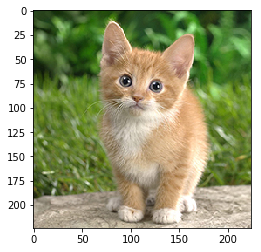

In [11]:
from tvm.contrib.download import download_testdata
from PIL import Image
from matplotlib import pyplot as plt

img_url = 'https://github.com/dmlc/mxnet.js/blob/master/data/cat.png?raw=true'
img_name = 'cat.png'
synset_url = ''.join(['https://gist.githubusercontent.com/zhreshold/',
                      '4d0b62f3d01426887599d4f7ede23ee5/raw/',
                      '596b27d23537e5a1b5751d2b0481ef172f58b539/',
                      'imagenet1000_clsid_to_human.txt'])
synset_name = 'imagenet1000_clsid_to_human.txt'
img_path = download_testdata(img_url, 'cat.png', module='data')
synset_path = download_testdata(synset_url, synset_name, module='data')
with open(synset_path) as f:
    synset = eval(f.read())
image = Image.open(img_path).resize((224, 224))
plt.imshow(image)
plt.show()

In [12]:
def transform_image(image):
    image = np.array(image) - np.array([123., 117., 104.])
    image /= np.array([58.395, 57.12, 57.375])
    image = image.transpose((2, 0, 1))
    image = image[np.newaxis, :]
    return image

x = transform_image(image)
print('x', x.shape)

x (1, 3, 224, 224)


In [13]:
ex.set_input('data', tvm.nd.array(x.astype("float32")))
# execute
ex.run()
# get outputs
tvm_output = ex.get_output(0)
top1 = np.argmax(tvm_output.asnumpy()[0])
print('TVM prediction top-1:', top1, synset[top1])

TVM prediction top-1: 282 tiger cat


Benchmark the mean inference time of TVM.

In [14]:
ftimer = ex.module.time_evaluator("run", tvm_ctx, number=10, min_repeat_ms=1000)
prof_res = np.array(ftimer().results) * 1000  # convert to millisecond
print("TVM mean inference time: %.2f ms" % np.mean(prof_res))

TVM mean inference time: 12.27 ms
